In [1]:
import os
import json
import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce
from shutil import copyfile
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', 500)

# Preprocessing

## Move text files 

In [2]:
# INSTRUCTIONS TO GENERATE TEXT FILES IN ONE FOLDER
# FROM MULTIPLE HTML FILES

def move_text_files() -> None:
    """Move text files from group files to a general file
    Convert html to text by removing tags
    Using BeautifulSoup library
    """
    for i in range(1, 17):
        html_files = [f for f in os.listdir(
            f"../rating_privacy_policies/group {i}") if f.endswith(".html")]
        for file in html_files:
            copyfile(
                f"../rating_privacy_policies/group {i}/" + file, "../text_files/" + file)

    for html_file in os.listdir("../text_files/"):
        with open("../text_files/" + html_file) as f:
            file_text = f.read()
            file_name = "".join(html_file.split('.')[:-1])
            with open("../text_files_pr/" + file_name + ".txt", "w") as tf:
                pr_text = BeautifulSoup(file_text).text
                tf.write(pr_text)
                
move_text_files()

## Read data

In [3]:
# Read data files
mean_ratings           = pd.read_excel('aggregate_ratings/mean_ratings.xlsx', index_col=0)
median_ratings         = pd.read_excel('aggregate_ratings/median_ratings.xlsx', index_col=0)
opp_115                = pd.read_json('annotated_privacy_policies/opp_115.json', orient='records')
non_comp_ratings       = pd.read_excel('annotated_privacy_policies/non-compliance-rating.xlsx')
non_compliance_data_practices = pd.read_json('annotated_privacy_policies/opp_115_non_compliance.json', orient='records')


In [4]:
def get_raw_text_from_files() -> pd.DataFrame:
    """
    Create a dataframe from the text files
    This function reads each file independently
    and store the text in a dataframe
    """
    raw_text = pd.Series(name="raw_text")

    for text_file in os.listdir("../text_files_pr/"):
        with open("../text_files_pr/" + text_file, "r") as tf:
            raw_text[text_file[:-7] + ".com"] = tf.read()

    raw_text = raw_text.to_frame()

    return raw_text


def preprocess_ratings(rating_df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the ratings dataframes
    to make them numeric
    and use the company names as rows
    to be consistent with other data sources
    """
    rating_df = rating_df.T
    rating_df.columns = rating_df.iloc[0]
    rating_df = (rating_df
                 .drop("Questions", axis=0)
                 .iloc[:, :-1]
                 .dropna(axis=1, how='all')
                 .astype(float)
                 .round(2)
                 )
    rating_df.index = [ind[:-5] for ind in rating_df.index]

    return rating_df

## Merge dataframes and add text

In [5]:
mean_ratings   = preprocess_ratings(mean_ratings)
median_ratings = preprocess_ratings(median_ratings)

non_comp_ratings = non_comp_ratings.iloc[:, :-2].dropna(how="all").set_index("Name")

non_comp_data_practices = non_compliance_data_practices.set_index("url_id")

raw_text = get_raw_text_from_files()

df_to_merge = [mean_ratings, median_ratings,
               non_comp_data_practices, non_comp_ratings, raw_text]

df_merged = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='left'),
                   df_to_merge)
df_merged.columns = [c.replace("_x", "_mean").replace(
    "_y", "_median") for c in df_merged.columns]

df = df_merged.copy()

<ipython-input-4-7e85586c76a0>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  raw_text = pd.Series(name="raw_text")


In [6]:
# Possibility to export the final
# dataframe as excel

export = False
if export:
    df_merged.to_excel("data_policies_merged.xlsx")

In [7]:
# Let's look at what is the dataframe processed

df_merged.head(2)

,"The privacy policy is clear, and I understand my privacy rights_mean",I understand the processing activities the company will perform on my data _mean,I am confident this privacy policy is compliant with transparency standards in data protection law_mean,This privacy policy wants to help consumers understand its privacy practices_mean,I am happy with the benefits I get from sharing my data_mean,The benefits outweigh my concerns for privacy_mean,I greatly benefit from the services of this company _mean,"In comparison with similar companies in this industry, this company provides greater benefits (independently of the data I share)_mean",I use or am very likely to use the services of this company_mean,This company collects and processes only the amount of data that is necessary for providing its services_mean,I am confident I can access the personal data this company collects about me_mean,I am happy with the extent of control I have over my data_mean,I am confident this company grants me and protects my rights for having control over my data _mean,I think this privacy policy wants to ensure I have control over my data_mean,I trust this company in general_mean,I trust this company with handling my data_mean,The risks of entrusting my data to this company are minimal_mean,"The privacy policy is clear, and I understand my privacy rights_median",I understand the processing activities the company will perform on my data _median,I am confident this privacy policy is compliant with transparency standards in data protection law_median,This privacy policy wants to help consumers understand its privacy practices_median,I am happy with the benefits I get from sharing my data_median,The benefits outweigh my concerns for privacy_median,I greatly benefit from the services of this company _median,"In comparison with similar companies in this industry, this company provides greater benefits (independently of the data I share)_median",I use or am very likely to use the services of this company_median,This company collects and processes only the amount of data that is necessary for providing its services_median,I am confident I can access the personal data this company collects about me_median,I am happy with the extent of control I have over my data_median,I am confident this company grants me and protects my rights for having control over my data _median,I think this privacy policy wants to ensure I have control over my data_median,I trust this company in general_median,I trust this company with handling my data_median,The risks of entrusting my data to this company are minimal_median,policy_id,rules,number,"Lawfulness, fairness and transparency",Purpose Limitation,Data Minimisation,Accuracy,Storage Limitation,Integrity and Confidentiality,Accountability,raw_text
1017_sci-news.com,5.67,4.33,5.00,5.33,4.00,3.67,2.33,3.33,2.33,5.33,5.00,4.33,4.33,4.33,4.0,4.00,5.67,6.0,6.0,5.0,5.0,4.0,4.0,2.0,4.0,2.0,6.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,3905,"[[{'category': 'First Party Collection/Use', '...",7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Privacy Policy Sci-News.com is committed to ...
1028_redorbit.com,6.00,5.00,5.33,5.33,4.67,4.00,3.67,4.00,3.00,5.33,4.67,4.67,5.33,5.33,4.0,5.33,6.00,7.0,7.0,6.0,6.0,5.0,5.0,4.0,4.0,2.0,7.0,6.0,6.0,7.0,7.0,4.0,6.0,7.0,3906,"[[{'category': 'First Party Collection/Use', '...",12,1.0,1.0,1.0,0.0,0.0,1.0,1.0,"RedOrbit, Inc. Privacy Statement |||This priv..."


# Modelling

### PaulEmile's code

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.lanear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_extraction.text import CountVectorizer

## Explain the trust coefficient

In [9]:
# Make groups of variables to manipulate 
# bigger categories T, B and C

benefit_variables = ["I am happy with the benefits I get from sharing my data_mean",
                     "The benefits outweigh my concerns for privacy_mean",
                     "In comparison with similar companies in this industry, this company provides greater benefits (independently of the data I share)_mean",
                     "I use or am very likely to use the services of this company_mean"]
transparenc_variables = ["The privacy policy is clear, and I understand my privacy rights_mean",
                         "I understand the processing activities the company will perform on my data _mean",
                         "I am confident this privacy policy is compliant with transparency standards in data protection law_mean",
                         "This privacy policy wants to help consumers understand its privacy practices_mean"]
control_variables = ["This company collects and processes only the amount of data that is necessary for providing its services_mean",
                     "I am confident I can access the personal data this company collects about me_mean",
                     "I am happy with the extent of control I have over my data_mean",
                     "I am confident this company grants me and protects my rights for having control over my data _mean",
                     "I think this privacy policy wants to ensure I have control over my data_mean"]
                     
                     
trust_variables = ["I trust this company in general_mean",
                   "The risks of entrusting my data to this company are minimal_mean",
                   "I trust this company with handling my data_mean"]

# Create category mean
df_merged["benefit_mean"]      = df_merged[benefit_variables]    .mean(axis=1)
df_merged["transparency_mean"] = df_merged[transparenc_variables].mean(axis=1)
df_merged["control_mean"]      = df_merged[control_variables]    .mean(axis=1)
df_merged["trust_mean"]        = df_merged[trust_variables]      .mean(axis=1)

In [10]:
# Build interaction variables
df_merged["B * T"] = df_merged["benefit_mean"] * df_merged["transparency_mean"]
df_merged["B * C"] = df_merged["benefit_mean"] * df_merged["control_mean"]
df_merged["C * T"] = df_merged["control_mean"] * df_merged["transparency_mean"]
df_merged["B * T * C"] = df_merged["benefit_mean"] * df_merged["control_mean"] * df_merged["transparency_mean"]

In [11]:
# Create variable selectors
base_variables = ["transparency_mean", "control_mean", "benefit_mean"]
interaction_variables = ["B * T", "B * C", "C * T", "B * T * C"]

# feats controls the subset of categories used
# you can use only base_variables
# or base_variables + interaction_variables

feats = base_variables + interaction_variables

In [12]:
# standardise variable to measure scale effect
# and compare coefficients
standard_sc = StandardScaler()

rough_mean = 4   # 4 is the mean of the columns

# Select the relevant data
# and fill nans with the mean
X_train = standard_sc.fit_transform(df_merged[feats].fillna(rough_mean))
y_train = df_merged["trust_mean"].fillna(rough_mean)

# Fit the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Gather the outcomes of the model
# R_square and coefficients of features
features_coef = {f + "_coef": round(s, 3) for (f, s) in zip(feats, lr.coef_)}
features_coef["determination_coef"] = round(r2_score(y_train, lr.predict(X_train)), 3)
features_coef["features_used"] = str(feats)

In [13]:
# Example with all features
df_interactions = pd.DataFrame(features_coef, index=["interactions"]).T
df_interactions

,interactions
transparency_mean_coef,0.552
control_mean_coef,-0.137
benefit_mean_coef,0.197
B * T_coef,-0.253
B * C_coef,0.961
C * T_coef,0.525
B * T * C_coef,-0.599
determination_coef,0.777
features_used,"['transparency_mean', 'control_mean', 'benefit..."


# Heatmap of correlation
### Tommy's code

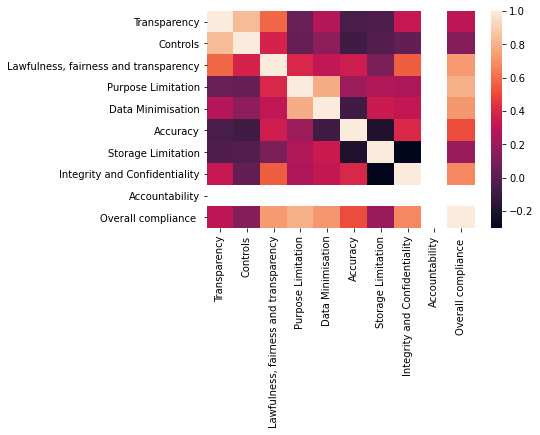

In [14]:
columns = mean_ratings.columns
mean_ratings['Transparency'] = mean_ratings[columns[:4]].mean(axis=1)
mean_ratings['Benefits'] = mean_ratings[columns[4:9]].mean(axis=1)
mean_ratings['Controls'] = mean_ratings[columns[9:]].mean(axis=1)

non_comp_ratings = pd.read_excel('annotated_privacy_policies/non-compliance-rating.xlsx')

non_comp_ratings.Name = non_comp_ratings.Name.apply(
    lambda x: str(x).replace('.com', '.com.html'))
for column in non_comp_ratings:
    try:
        non_comp_ratings[column] = non_comp_ratings[column].astype('float')
    except:
        pass
hm = sns.heatmap(mean_ratings.join(non_comp_ratings.set_index('Name'))[['Transparency', 'Controls', 'Lawfulness, fairness and transparency', 'Purpose Limitation',
                                                                        'Data Minimisation', 'Accuracy', 'Storage Limitation',
                                                                        'Integrity and Confidentiality', 'Accountability',
                                                                        'Overall compliance ']].corr(), xticklabels=True)
hm

# NLP Approach
### Etienne Code

## Explanation of NLP approach
* The purpose of this analysis is to identify words and phrases that might impact the opinion of readers when going through the Terms of Service.
* This is achieved by creating a bag of words vector of the text for each ToS, thus creating a vocabulary of all the words used. Then, a linear model is fit using the resulting text vector and each of the features in the dataset. The larger the coefficient of a particular word, the most it contributes to increasing the grade the reader will give the feature.

In [15]:
def get_text_arr(df, ngram_range, binary):
    cv = CountVectorizer(ngram_range=ngram_range, min_df=4,
                         max_df=0.75, binary=binary)
    text_arr = cv.fit_transform(df['raw_text'].values)
    print(text_arr.shape[1], 'tokens')
    return text_arr, cv


def min_max_scale(array):
    return (array - array.min()) / (array.max() - array.min())


def print_top(coefs, vocab, text_arr, top=10):
    for idx in coefs.argsort()[::-1][:top]:
        print(
            f"{vocab[idx]:35s} : {coefs[idx]:7.4f} | {text_arr[:, idx].sum():>3} occurences")


def print_bottom(coefs, vocab, text_arr, bot=10):
    for idx in coefs.argsort()[:bot]:
        print(
            f"{vocab[idx]:35s} : {coefs[idx]:7.4f} | {text_arr[:, idx].sum():>3} occurences")


def fit_model(text_arr, feature_arr, model):
    feature_scaled = min_max_scale(feature_arr)
    model.fit(text_arr, feature_scaled)
    return model


def get_token_scores(model, text_arr, feature, vocab):
    print(f'Feature: {feature}')
    print('---')
    model = fit_model(text_arr, df[feature], model)
    print('[top tokens]')
    print_top(model.coef_, vocab, text_arr, top=10)
    print('---')
    print('[bottom tokens]')
    print_bottom(model.coef_, vocab, text_arr, bot=10)

In [16]:
features = list(df.columns[1:-1])
features.remove('rules')

for i, feature in enumerate(features[:10]):
    print(i, '-', feature)

0 - I understand the processing activities the company will perform on my data _mean
1 - I am confident this privacy policy is compliant with transparency standards in data protection law_mean
2 - This privacy policy wants to help consumers understand its privacy practices_mean
3 - I am happy with the benefits I get from sharing my data_mean
4 - The benefits outweigh my concerns for privacy_mean
5 - I greatly benefit from the services of this company _mean
6 - In comparison with similar companies in this industry, this company provides greater benefits (independently of the data I share)_mean
7 - I use or am very likely to use the services of this company_mean
8 - This company collects and processes only the amount of data that is necessary for providing its services_mean
9 - I am confident I can access the personal data this company collects about me_mean


In [17]:
# Let's prepare the data 
# and fit the model

df = df.dropna(subset=["raw_text"])
text_arr, cv = get_text_arr(df, ngram_range=(4, 4), binary=True)
vocab = cv.get_feature_names()
model = LinearRegression()

4463 tokens


In [18]:
# On this example, we can see that
# "third party" harms the score
# for this category

get_token_scores(model, text_arr, features[0], vocab)

Feature: I understand the processing activities the company will perform on my data _mean
---
[top tokens]
this privacy policy how             :  0.1117 |   4 occurences
our web site or                     :  0.0554 |   4 occurences
to collect personal information     :  0.0547 |   5 occurences
not responsible for the             :  0.0545 |  38 occurences
and we do not                       :  0.0530 |  15 occurences
your interaction with the           :  0.0525 |   4 occurences
personal information and we         :  0.0519 |   7 occurences
information from your computer      :  0.0509 |   8 occurences
your computer when you              :  0.0504 |   6 occurences
on your computer when               :  0.0502 |   5 occurences
---
[bottom tokens]
third party advertising networks    : -0.1000 |   8 occurences
to any third party                  : -0.0847 |  11 occurences
identifiable information collected from : -0.0814 |   4 occurences
if at any time                      : -0.0677 |  1

# Correlation between user grading and expert annotation

### Romain and Thomas code

In [19]:
# Create 'TBCT' columns based on user's answers
df_merged["benefits"]     = df_merged[benefit_variables]    .mean(axis=1)
df_merged["transparency"] = df_merged[transparenc_variables].mean(axis=1)
df_merged["control"]      = df_merged[control_variables]    .mean(axis=1)
df_merged["trust"]        = df_merged[trust_variables]      .mean(axis=1)

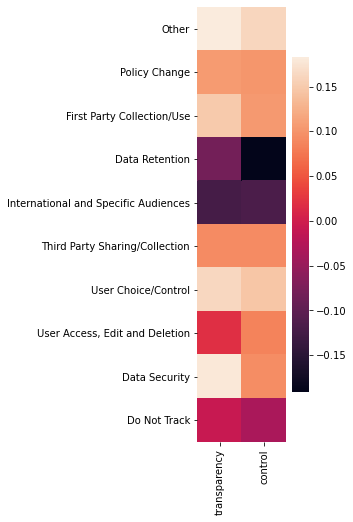

In [20]:
# Count number of occurences of each category in the data policy of each company
dict_category = {}
for url_id, dictio in zip(opp_115.url_id, opp_115.attribute_value_pairs):
    for category in dictio:
        if not category in dict_category:
            dict_category[category] = {url_id: 1}
        else:
            if not url_id in dict_category[category]:
                dict_category[category][url_id] = 1
            else:
                dict_category[category][url_id] += 1

# Add this count of categories to the dataframe
df_merged_w_category = pd.merge(df_merged, pd.DataFrame(
    dict_category), left_index=True, right_index=True)

# Create a correlation matrix heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(df_merged_w_category[['transparency', 'control', 'Other', 'Policy Change', 'First Party Collection/Use',
                                  'Data Retention', 'International and Specific Audiences',
                                  'Third Party Sharing/Collection', 'User Choice/Control',
                                  'User Access, Edit and Deletion', 'Data Security', 'Do Not Track']].corr().iloc[2:, :2])